# Image Classification with Deep Learning: Detecting Pneumonia

## Import Packages

In [241]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix
from keras import regularizers
import keras.models as models
import keras.layers as layers
from keras.models import load_model
from tensorflow.keras import optimizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19
import seaborn as sns


# Business Problem

The objective of this project is to create a model that can accurately detect pneumonia in patients when provided with an x-ray of their lungs.


## Methodology

This project will follow the CRISP-DM approach


<img src="figures/CRISPDM_Process_Diagram.png" style='width:600px;height:600px'/>

## The Data

The data was downloaded from [kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) and is already split into training, test and validation data. 

- There are 5,863 images in this dataset
- The images are classified into two categories: 1. Pneumonia present 2. Pneumonia not present

### Loading the Data

As the data required for this project are too large, they have not been uploaded to this Git Repo. To download the data, please visit the kaggle link above.

In [5]:
# create paths for data
train_data = 'chest_xray/train'
test_data = 'chest_xray/test'
val_data = 'chest_xray/val'

# Create paths for each data set
train_pneumonia = 'chest_xray/train/PNEUMONIA'
test_pneumonia = 'chest_xray/test/PNEUMONIA'
train_normal = 'chest_xray/train/NORMAL'
test_normal = 'chest_xray/test/NORMAL'
val_normal = 'chest_xray/val/NORMAL'
val_pneumonia = 'chest_xray/val/PNEUMONIA'

paths = [train_pneumonia,test_pneumonia,train_normal,test_normal,val_normal,val_pneumonia]

In [6]:
# determine the size of the datasets
test_size = len(os.listdir(test_pneumonia))+len(os.listdir(test_normal))
train_size = len(os.listdir(train_pneumonia))+len(os.listdir(train_normal))
val_size = len(os.listdir(val_pneumonia))+len(os.listdir(val_normal))


print('Test size is {}'.format(test_size))
print('Train size is {}'.format(train_size))
print('Val size is {}'.format(val_size))

Test size is 624
Train size is 5216
Val size is 16


### Split Data

The validation data is quite small, it may be worth redistributing the images from train/test/val so the val dataset is larger, at least 100 images.

In [7]:
# creating list of files in training set to be moved
pneumonia_train_imgs = [file for file in os.listdir(train_pneumonia)]
normal_train_imgs = [file for file in os.listdir(train_normal)]

In the two cells below I have set out code to rearrange the size of the validation data by taking images from the training set. I have commented out these cells so they do rearrange the directories further.

In [10]:
# # Increase size of pneumonia val set
# imgs = pneumonia_train_imgs[-400:]
# for img in imgs:
#     origin = os.path.join(train_pneumonia, img)
#     destination = val_pneumonia
#     shutil.move(origin, destination)

In [12]:
# # Increase size of normal val set
# imgs = normal_train_imgs[-140:]
# for img in imgs:
#     origin = os.path.join(train_normal, img)
#     destination = val_normal
#     shutil.move(origin, destination)

In [14]:
test_size = len(os.listdir(test_pneumonia))+len(os.listdir(test_normal))
train_size = len(os.listdir(train_pneumonia))+len(os.listdir(train_normal))
val_size = len(os.listdir(val_pneumonia))+len(os.listdir(val_normal))

print('Test size is {}'.format(test_size))
print('Train size is {}'.format(train_size))
print('Val size is {}'.format(val_size))

Test size is 624
Train size is 4676
Val size is 556


In [239]:
test_size+train_size+val_size

5856

The validation data has increased from 16 to 556, much better.

### Data Preparation

For this portion, there will be no data augmentation, just the rescaling of images.

In [134]:
generator = ImageDataGenerator(rescale=1.0/255.0)

# Get all the data in the directory chest_xrays/test and resize
test_gen = generator.flow_from_directory(
        'chest_xray/test', 
        target_size=(100, 100), 
        batch_size=624)

# Get all the data in the directory chest_xrays/train and resize
train_gen = generator.flow_from_directory(
        'chest_xray/train', 
        target_size=(100, 100), 
        batch_size=4676)

# create a validation dataset
val_gen = generator.flow_from_directory(
        'chest_xray/val', 
        target_size=(100, 100), 
        batch_size=556)

Found 624 images belonging to 2 classes.
Found 4676 images belonging to 2 classes.
Found 556 images belonging to 2 classes.


In [135]:
# Create the datasets
train_images, train_labels = next(train_gen)
test_images, test_labels = next(test_gen)
val_images, val_labels = next(val_gen)

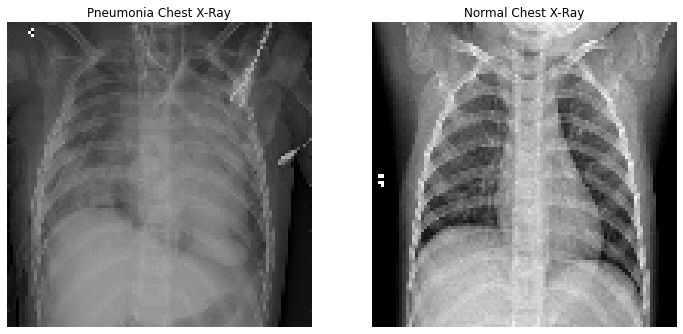

In [235]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(np.squeeze(train_images[0]))
axes[1].imshow(np.squeeze(train_images[3]))
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Pneumonia Chest X-Ray')
axes[1].set_title('Normal Chest X-Ray')
plt.show()
fig.savefig('figures/xrays.png', bbox_inches='tight')

### Explore Class Balance

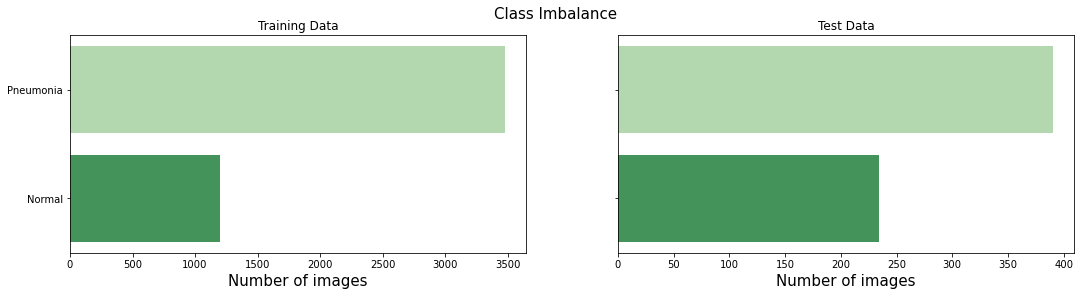

In [238]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,4), sharey=True)

sns.barplot(x=[len(os.listdir(train_pneumonia)),len(os.listdir(train_normal))],
            y=[ 'Pneumonia', 'Normal'],
            palette='Greens', ax=axes[0])
sns.barplot(x=[len(os.listdir(test_pneumonia)),len(os.listdir(test_normal))],
            y=[ 'Pneumonia', 'Normal'],
            palette='Greens',ax=axes[1])
axes[1].set_xlabel('Number of images', fontsize=15)
axes[0].set_xlabel('Number of images', fontsize=15)
axes[1].set_title('Test Data')
axes[0].set_title('Training Data')
fig.suptitle('Class Imbalance', fontsize=15)
fig.savefig('figures/classimbalance.png', bbox_inches='tight')

### Fix Shape of Data

In [136]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))
print(np.shape(val_images))
print(np.shape(val_labels))

(4676, 100, 100, 3)
(4676, 2)
(624, 100, 100, 3)
(624, 2)
(556, 100, 100, 3)
(556, 2)


In [138]:
# Reshape the train images 
train_img = train_images.reshape(4676,-1)
test_img = test_images.reshape(624,-1)
val_img = val_images.reshape(556,-1)

In [139]:
train_lab = np.reshape(train_labels[:,1],(4676,1))
test_lab = np.reshape(test_labels[:,1],(624,1))
val_lab = np.reshape(val_labels[:,1],(556,1))

In [140]:
print(train_img.shape)
print(test_img.shape)
print(val_img.shape)
print(train_lab.shape)
print(test_lab.shape)
print(val_lab.shape)

(4676, 30000)
(624, 30000)
(556, 30000)
(4676, 1)
(624, 1)
(556, 1)


# Create Baseline Model

For the baseline model I will build a deep neural network with just an input layer, two hidden layers and one output layer.

In [141]:
base_nn = models.Sequential()


# Add dense layers with relu activation
base_nn.add(layers.Dense(20, activation='relu', input_shape = (30000,))) 
base_nn.add(layers.Dense(20, activation='relu'))
base_nn.add(layers.Dense(5, activation='relu'))

# Add final layer with sigmoid activation
base_nn.add(layers.Dense(1, activation='sigmoid'))

In [142]:
# Get summary
base_nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                600020    
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 600,551
Trainable params: 600,551
Non-trainable params: 0
_________________________________________________________________


With regards to the optimiser to use, I will use 'Nadam' for now, with more time I could experiment with different optimizers and select the optimum.  

In [143]:
base_nn.compile(loss = 'binary_crossentropy',
              optimizer = 'Nadam',
              metrics = ['accuracy'])

In [144]:
base_nn_history = base_nn.fit(train_img, train_lab, epochs = 100, batch_size = 100, verbose = 1,
                    validation_data = (val_img, val_lab))

Epoch 1/100
47/47 [==============================] - 4s 85ms/step - loss: 0.7184 - accuracy: 0.7025 - val_loss: 0.4328 - val_accuracy: 0.7410
Epoch 2/100
47/47 [==============================] - 2s 34ms/step - loss: 0.3580 - accuracy: 0.8409 - val_loss: 0.2703 - val_accuracy: 0.9047
Epoch 3/100
47/47 [==============================] - 1s 31ms/step - loss: 0.3079 - accuracy: 0.8680 - val_loss: 0.3981 - val_accuracy: 0.8381
Epoch 4/100
47/47 [==============================] - 2s 32ms/step - loss: 0.2458 - accuracy: 0.8984 - val_loss: 0.2016 - val_accuracy: 0.9299
Epoch 5/100
47/47 [==============================] - 1s 31ms/step - loss: 0.2401 - accuracy: 0.9008 - val_loss: 0.7556 - val_accuracy: 0.7752
Epoch 6/100
47/47 [==============================] - 1s 30ms/step - loss: 0.2211 - accuracy: 0.9127 - val_loss: 0.1743 - val_accuracy: 0.9424
Epoch 7/100
47/47 [==============================] - 1s 29ms/step - loss: 0.1692 - accuracy: 0.9373 - val_loss: 0.3847 - val_accuracy: 0.8579
Epoch 

### Evaluate Baseline on Test Data

In [145]:
print("Loss of the model is - " , base_nn.evaluate(test_img, test_lab)[0]*100 , "%")
print("Accuracy of the model is - " , base_nn.evaluate(test_img, test_lab)[1]*100 , "%")

20/20 [==============================] - 0s 7ms/step - loss: 0.7275 - accuracy: 0.8125
Loss of the model is -  72.75285720825195 %
20/20 [==============================] - 0s 4ms/step - loss: 0.7275 - accuracy: 0.8125
Accuracy of the model is -  81.25 %


In [148]:
y_pred_base_nn = base_nn.predict(test_img)
y_pred_base_nn = np.rint(y_pred_base_nn)
print(classification_report(test_lab, y_pred_base_nn, labels=[0,1]))
cm_base_nn = confusion_matrix(test_lab, y_pred_base_nn)

              precision    recall  f1-score   support

           0       0.91      0.56      0.69       234
           1       0.78      0.97      0.87       390

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.78       624
weighted avg       0.83      0.81      0.80       624



Confusion matrix, without normalization


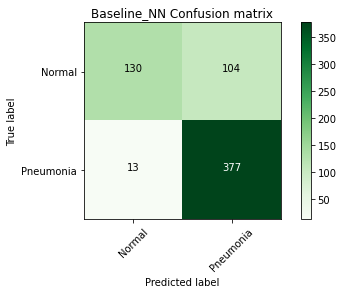

In [149]:
plot_confusion_matrix(cm=cm_base_nn, classes=['Normal', 'Pneumonia'], filename='Baseline_NN')

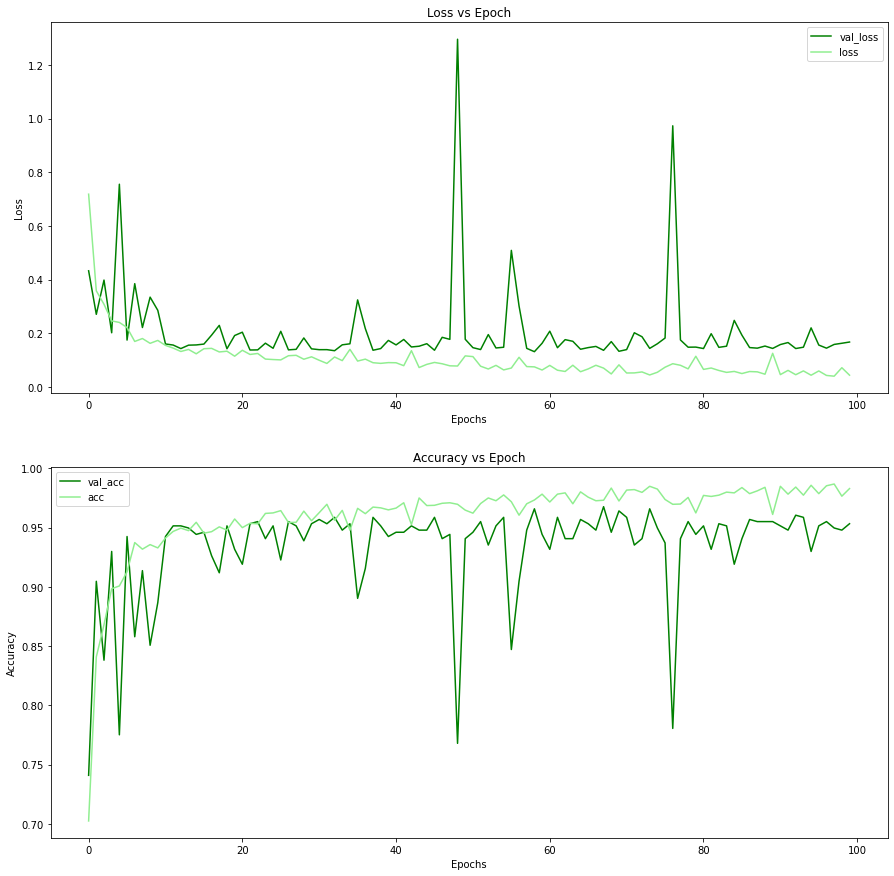

In [150]:
get_plots(base_nn_history, title='base_nn_plots.png')

The baseline model is surprisingly good, accuracy of 0.81 and minority recall of 0.56 - this will be the most challenging metric. The recall of the pneumonia class is only 0.97 meaning 13 pneumonia cases are missed. Can this be improved?
Overfitting does not appear to be a big issue here, but perhaps a plateau in the val accuracy whilst training accuracy increases shows there is some overfitting to an extent. 

# Base CNN Model

In [153]:
base_cnn = models.Sequential()

base_cnn.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape = (100,100,3)))
base_cnn.add(MaxPooling2D((2, 2)))

base_cnn.add(Conv2D(32, (4, 4), activation='relu'))
base_cnn.add(MaxPooling2D(2, 2))

base_cnn.add(Conv2D(64, (3, 3), activation='relu'))
base_cnn.add(MaxPooling2D((2, 2)))

base_cnn.add(Flatten())
base_cnn.add(Dense(64, activation='relu'))
base_cnn.add(Dense(1, activation='sigmoid'))

base_cnn.compile(loss='binary_crossentropy',
                optimizer='Nadam',
                metrics=['accuracy'])


In [154]:
base_cnn_history = base_cnn.fit(train_images,
                       train_lab,
                       epochs=100,
                       batch_size=100,
                       validation_data=(val_images, val_lab))

Epoch 1/100
47/47 [==============================] - 66s 1s/step - loss: 0.4643 - accuracy: 0.8062 - val_loss: 0.2032 - val_accuracy: 0.9353
Epoch 2/100
47/47 [==============================] - 63s 1s/step - loss: 0.2030 - accuracy: 0.9211 - val_loss: 0.1874 - val_accuracy: 0.9227
Epoch 3/100
47/47 [==============================] - 61s 1s/step - loss: 0.1278 - accuracy: 0.9512 - val_loss: 0.1469 - val_accuracy: 0.9424
Epoch 4/100
47/47 [==============================] - 62s 1s/step - loss: 0.0841 - accuracy: 0.9688 - val_loss: 0.1391 - val_accuracy: 0.9460
Epoch 5/100
47/47 [==============================] - 66s 1s/step - loss: 0.0768 - accuracy: 0.9726 - val_loss: 0.1550 - val_accuracy: 0.9442
Epoch 6/100
47/47 [==============================] - 62s 1s/step - loss: 0.0869 - accuracy: 0.9683 - val_loss: 0.1801 - val_accuracy: 0.9353
Epoch 7/100
47/47 [==============================] - 61s 1s/step - loss: 0.0568 - accuracy: 0.9795 - val_loss: 0.1303 - val_accuracy: 0.9586
Epoch 8/100
4

### Evaluate Baseline CNN on Test Data

In [155]:
print("Loss of the model is - " , base_cnn.evaluate(test_images, test_lab)[0]*100 , "%")
print("Accuracy of the model is - " , base_cnn.evaluate(test_images, test_lab)[1]*100 , "%")

20/20 [==============================] - 3s 126ms/step - loss: 3.8340 - accuracy: 0.7628
Loss of the model is -  383.39593410491943 %
20/20 [==============================] - 3s 129ms/step - loss: 3.8340 - accuracy: 0.7628
Accuracy of the model is -  76.28205418586731 %


In [156]:
y_pred_base_cnn = base_cnn.predict(test_images)
y_pred_base_cnn = np.rint(y_pred_base_cnn)
print(classification_report(test_lab, y_pred_base_cnn, labels=[0,1]))
cm_base_cnn = confusion_matrix(test_lab, y_pred_base_cnn)

              precision    recall  f1-score   support

           0       0.98      0.38      0.54       234
           1       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.69      0.69       624
weighted avg       0.82      0.76      0.73       624



Confusion matrix, without normalization


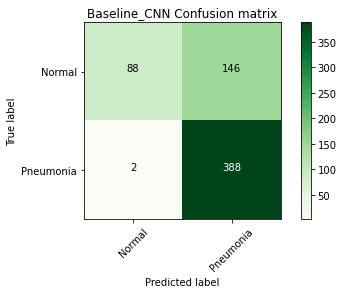

In [157]:
plot_confusion_matrix(cm=cm_base_cnn, classes=['Normal', 'Pneumonia'], filename='Baseline_CNN')

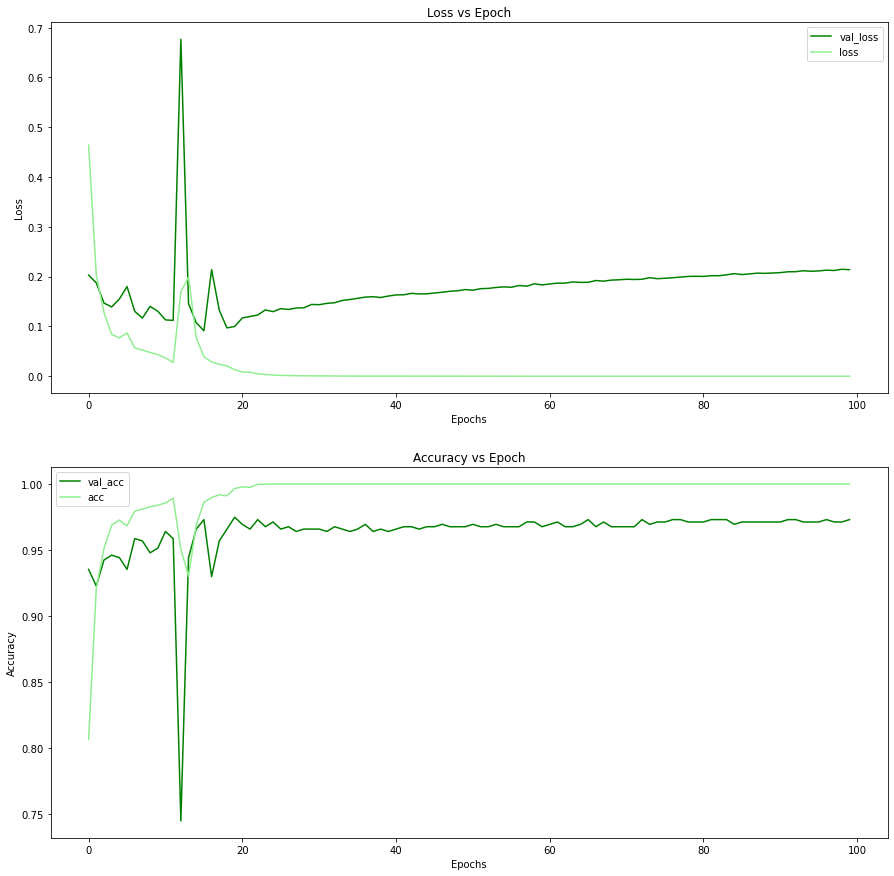

In [158]:
get_plots(base_cnn_history, title='base_cnn_plots.png')

There is clear evidence of overfitting here with the training data continuing to improve and the validation scores remaining constant or infact getting worse. I will try and address this in the next model and I will also introduce an early stop to save the best model, the point at which validation loss stops improving. This will save time in the modelling process. 

# Add Dropout to CNN

In [160]:
dropout_cnn = models.Sequential()

dropout_cnn.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape = (100,100,3)))
dropout_cnn.add(MaxPooling2D((2, 2)))
dropout_cnn.add(layers.Dropout(0.2))
dropout_cnn.add(Conv2D(32, (4, 4), activation='relu'))
dropout_cnn.add(MaxPooling2D(2, 2))
dropout_cnn.add(layers.Dropout(0.2))
dropout_cnn.add(Conv2D(64, (3, 3), activation='relu'))
dropout_cnn.add(MaxPooling2D((2, 2)))
dropout_cnn.add(layers.Dropout(0.2))
dropout_cnn.add(Flatten())
dropout_cnn.add(Dense(64, activation='relu'))
dropout_cnn.add(layers.Dropout(0.2))
dropout_cnn.add(Dense(1, activation='sigmoid'))

dropout_cnn.compile(loss='binary_crossentropy',
                optimizer='Nadam',
                metrics=['accuracy'])

In [161]:
callbacks_dropout_cnn = [EarlyStopping(monitor='val_loss', patience=10, verbose=0), 
                  ModelCheckpoint(filepath='models/best_cnn_dropout.h5', monitor='val_loss', save_best_only=True)]

In [162]:
cnn_dropout_history = dropout_cnn.fit(train_images,
                       train_lab,
                       epochs=100,
                       batch_size=100,
                       validation_data=(val_images, val_lab), callbacks=callbacks_dropout_cnn)

Epoch 1/100
47/47 [==============================] - 72s 2s/step - loss: 0.5614 - accuracy: 0.7466 - val_loss: 0.4930 - val_accuracy: 0.7680
Epoch 2/100
47/47 [==============================] - 70s 1s/step - loss: 0.3779 - accuracy: 0.8180 - val_loss: 0.4299 - val_accuracy: 0.8579
Epoch 3/100
47/47 [==============================] - 70s 1s/step - loss: 0.2662 - accuracy: 0.8843 - val_loss: 0.2422 - val_accuracy: 0.9299
Epoch 4/100
47/47 [==============================] - 72s 2s/step - loss: 0.1908 - accuracy: 0.9194 - val_loss: 0.2085 - val_accuracy: 0.9299
Epoch 5/100
47/47 [==============================] - 71s 2s/step - loss: 0.1548 - accuracy: 0.9384 - val_loss: 0.1684 - val_accuracy: 0.9371
Epoch 6/100
47/47 [==============================] - 71s 2s/step - loss: 0.1378 - accuracy: 0.9487 - val_loss: 0.1628 - val_accuracy: 0.9335
Epoch 7/100
47/47 [==============================] - 72s 2s/step - loss: 0.1329 - accuracy: 0.9461 - val_loss: 0.1617 - val_accuracy: 0.9371
Epoch 8/100
4

### Evaluate CNN with Dropout on Test Data

In [163]:
print("Loss of the model is - " , dropout_cnn.evaluate(test_images, test_lab)[0]*100 , "%")
print("Accuracy of the model is - " , dropout_cnn.evaluate(test_images, test_lab)[1]*100 , "%")

20/20 [==============================] - 3s 126ms/step - loss: 1.4015 - accuracy: 0.7644
Loss of the model is -  140.15390872955322 %
20/20 [==============================] - 2s 124ms/step - loss: 1.4015 - accuracy: 0.7644
Accuracy of the model is -  76.44230723381042 %


In [164]:
y_pred_drop_cnn = dropout_cnn.predict(test_images)
y_pred_drop_cnn = np.rint(y_pred_drop_cnn)
print(classification_report(test_lab, y_pred_drop_cnn, labels=[0,1]))
cm_drop_cnn = confusion_matrix(test_lab, y_pred_drop_cnn)

              precision    recall  f1-score   support

           0       0.98      0.38      0.55       234
           1       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.69      0.69       624
weighted avg       0.82      0.76      0.73       624



Confusion matrix, without normalization


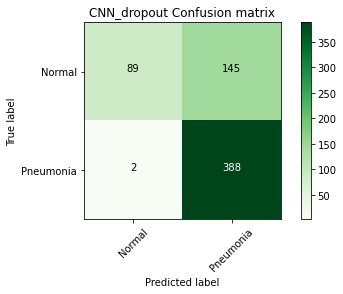

In [165]:
plot_confusion_matrix(cm=cm_drop_cnn, classes=['Normal', 'Pneumonia'], filename='CNN_dropout')

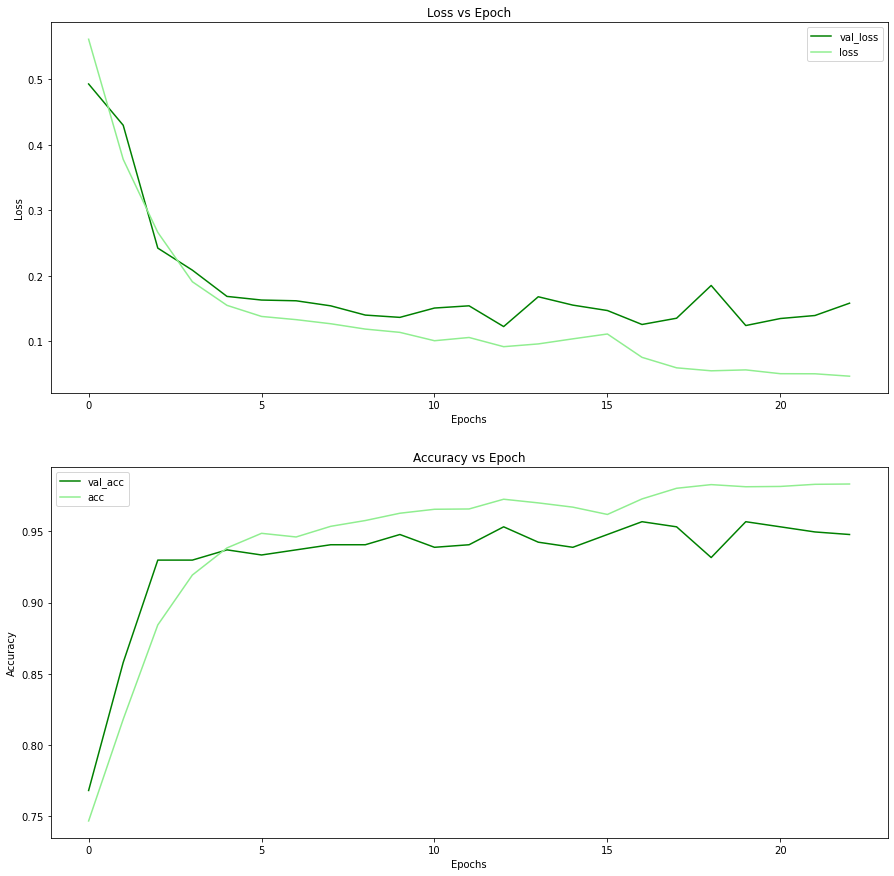

In [167]:
get_plots(cnn_dropout_history, title='drop_cnn_plots.png')

# Deeper Model

In [168]:
deeper_cnn = models.Sequential()

deeper_cnn.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape = (100,100,3)))
deeper_cnn.add(MaxPooling2D((2, 2)))

deeper_cnn.add(Conv2D(64, (4, 4), activation='relu'))
deeper_cnn.add(MaxPooling2D(2, 2))
deeper_cnn.add(layers.Dropout(0.2))

deeper_cnn.add(Conv2D(128, (3, 3), activation='relu'))
deeper_cnn.add(MaxPooling2D((2, 2)))
deeper_cnn.add(layers.Dropout(0.2))

deeper_cnn.add(Conv2D(256, (3, 3), activation='relu'))
deeper_cnn.add(MaxPooling2D((2, 2)))

deeper_cnn.add(Flatten())
deeper_cnn.add(layers.Dropout(0.2))
deeper_cnn.add(Dense(256, activation='relu'))
deeper_cnn.add(Dense(1, activation='sigmoid'))

deeper_cnn.compile(loss='binary_crossentropy',
                optimizer='Nadam',
                metrics=['accuracy'])

In [171]:
callbacks_deep_cnn = [EarlyStopping(monitor='val_loss', patience=10, verbose=0), 
                  ModelCheckpoint(filepath='models/best_cnn_deep.h5', monitor='val_loss', save_best_only=True)]

In [172]:
cnn_deep_history = deeper_cnn.fit(train_images,
                       train_lab,
                       epochs=100,
                       batch_size=100,
                       validation_data=(val_images, val_lab), callbacks=callbacks_deep_cnn)

Epoch 1/100
47/47 [==============================] - 108s 2s/step - loss: 0.5783 - accuracy: 0.7301 - val_loss: 3.0361 - val_accuracy: 0.7338
Epoch 2/100
47/47 [==============================] - 105s 2s/step - loss: 0.5094 - accuracy: 0.8296 - val_loss: 0.2962 - val_accuracy: 0.8975
Epoch 3/100
47/47 [==============================] - 112s 2s/step - loss: 0.1961 - accuracy: 0.9213 - val_loss: 0.2118 - val_accuracy: 0.9209
Epoch 4/100
47/47 [==============================] - 126s 3s/step - loss: 0.1198 - accuracy: 0.9551 - val_loss: 0.1567 - val_accuracy: 0.9424
Epoch 5/100
47/47 [==============================] - 110s 2s/step - loss: 0.1724 - accuracy: 0.9405 - val_loss: 0.1935 - val_accuracy: 0.9209
Epoch 6/100
47/47 [==============================] - 105s 2s/step - loss: 0.1004 - accuracy: 0.9624 - val_loss: 0.1504 - val_accuracy: 0.9442
Epoch 7/100
47/47 [==============================] - 106s 2s/step - loss: 0.0794 - accuracy: 0.9713 - val_loss: 0.1726 - val_accuracy: 0.9317
Epoch 

### Evaluate Deeper CNN on Test Data

In [174]:
print("Loss of the model is - " , deeper_cnn.evaluate(test_images, test_lab)[0]*100 , "%")
print("Accuracy of the model is - " , deeper_cnn.evaluate(test_images, test_lab)[1]*100 , "%")

20/20 [==============================] - 4s 202ms/step - loss: 1.0546 - accuracy: 0.8125
Loss of the model is -  105.46027421951294 %
20/20 [==============================] - 4s 197ms/step - loss: 1.0546 - accuracy: 0.8125
Accuracy of the model is -  81.25 %


In [175]:
y_pred_deep_cnn = deeper_cnn.predict(test_images)
y_pred_deep_cnn = np.rint(y_pred_deep_cnn)
print(classification_report(test_lab, y_pred_deep_cnn, labels=[0,1]))
cm_deep_cnn = confusion_matrix(test_lab, y_pred_deep_cnn)

              precision    recall  f1-score   support

           0       0.98      0.51      0.67       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.79       624



Confusion matrix, without normalization


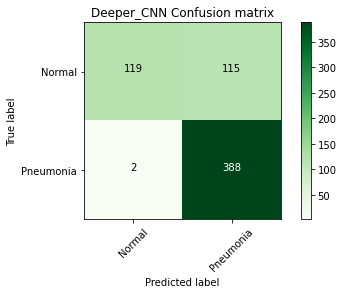

In [176]:
plot_confusion_matrix(cm=cm_deep_cnn, classes=['Normal', 'Pneumonia'], filename='Deeper_CNN')

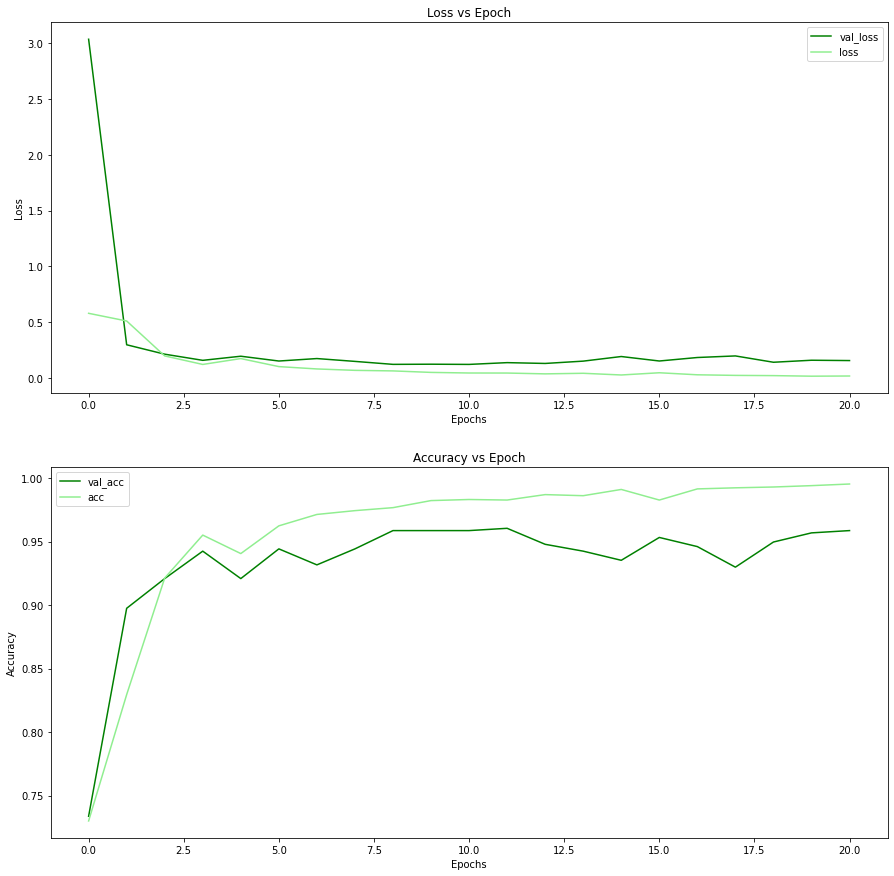

In [177]:
get_plots(cnn_deep_history, title='deep_cnn_plots.png')

less evidence of overfitting here but still a bit of a drop off between train and test performance, I will add some L2 regularisation to see if this improves matters with regards to test scores.

# Deep CNN with L2 Regularization

In [178]:
deeper_cnn_l2 = models.Sequential()

deeper_cnn_l2.add(Conv2D(32, (3, 3), activation='relu',
                    input_shape = (100,100,3)))
deeper_cnn_l2.add(MaxPooling2D((2, 2)))

deeper_cnn_l2.add(Conv2D(64, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
deeper_cnn_l2.add(MaxPooling2D(2, 2))
deeper_cnn_l2.add(layers.Dropout(0.2))

deeper_cnn_l2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
deeper_cnn_l2.add(MaxPooling2D((2, 2)))
deeper_cnn_l2.add(layers.Dropout(0.2))

deeper_cnn_l2.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
deeper_cnn_l2.add(MaxPooling2D((2, 2)))

deeper_cnn_l2.add(Flatten())
deeper_cnn_l2.add(layers.Dropout(0.2))
deeper_cnn_l2.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
deeper_cnn_l2.add(Dense(1, activation='sigmoid'))

deeper_cnn_l2.compile(loss='binary_crossentropy',
                optimizer='Nadam',
                metrics=['accuracy'])

In [179]:
callbacks_deep_cnn_l2 = [EarlyStopping(monitor='val_loss', patience=10, verbose=0), 
                  ModelCheckpoint(filepath='models/best_cnn_deep_l2.h5', monitor='val_loss', save_best_only=True)]

In [180]:
cnn_deep_l2_history = deeper_cnn_l2.fit(train_images,
                       train_lab,
                       epochs=100,
                       batch_size=100,
                       validation_data=(val_images, val_lab), callbacks=callbacks_deep_cnn_l2)

Epoch 1/100
47/47 [==============================] - 110s 2s/step - loss: 2.3282 - accuracy: 0.7331 - val_loss: 1.0845 - val_accuracy: 0.7338
Epoch 2/100
47/47 [==============================] - 96s 2s/step - loss: 0.8795 - accuracy: 0.7483 - val_loss: 0.7424 - val_accuracy: 0.7338
Epoch 3/100
47/47 [==============================] - 96s 2s/step - loss: 0.6630 - accuracy: 0.7628 - val_loss: 0.5132 - val_accuracy: 0.8201
Epoch 4/100
47/47 [==============================] - 106s 2s/step - loss: 0.4458 - accuracy: 0.8638 - val_loss: 0.3624 - val_accuracy: 0.9101
Epoch 5/100
47/47 [==============================] - 114s 2s/step - loss: 0.3488 - accuracy: 0.9021 - val_loss: 0.3121 - val_accuracy: 0.9209
Epoch 6/100
47/47 [==============================] - 120s 3s/step - loss: 0.3139 - accuracy: 0.9138 - val_loss: 0.3050 - val_accuracy: 0.9119
Epoch 7/100
47/47 [==============================] - 111s 2s/step - loss: 0.2980 - accuracy: 0.9243 - val_loss: 0.3103 - val_accuracy: 0.9263
Epoch 8/

### Evaluation of Deep CNN with L2

In [182]:
print("Loss of the model is - " , deeper_cnn_l2.evaluate(test_images, test_lab)[0]*100 , "%")
print("Accuracy of the model is - " , deeper_cnn_l2.evaluate(test_images, test_lab)[1]*100 , "%")

20/20 [==============================] - 4s 182ms/step - loss: 0.7840 - accuracy: 0.7788
Loss of the model is -  78.39840650558472 %
20/20 [==============================] - 4s 185ms/step - loss: 0.7840 - accuracy: 0.77881s - loss:
Accuracy of the model is -  77.88461446762085 %


In [183]:
y_pred_deep_cnn_l2 = deeper_cnn_l2.predict(test_images)
y_pred_deep_cnn_l2 = np.rint(y_pred_deep_cnn_l2)
print(classification_report(test_lab, y_pred_deep_cnn_l2, labels=[0,1]))
cm_deep_cnn_l2 = confusion_matrix(test_lab, y_pred_deep_cnn_l2)

              precision    recall  f1-score   support

           0       0.98      0.42      0.59       234
           1       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.72       624
weighted avg       0.83      0.78      0.75       624



Confusion matrix, without normalization


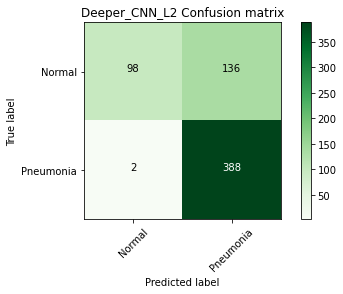

In [184]:
plot_confusion_matrix(cm=cm_deep_cnn_l2, classes=['Normal', 'Pneumonia'], filename='Deeper_CNN_L2')

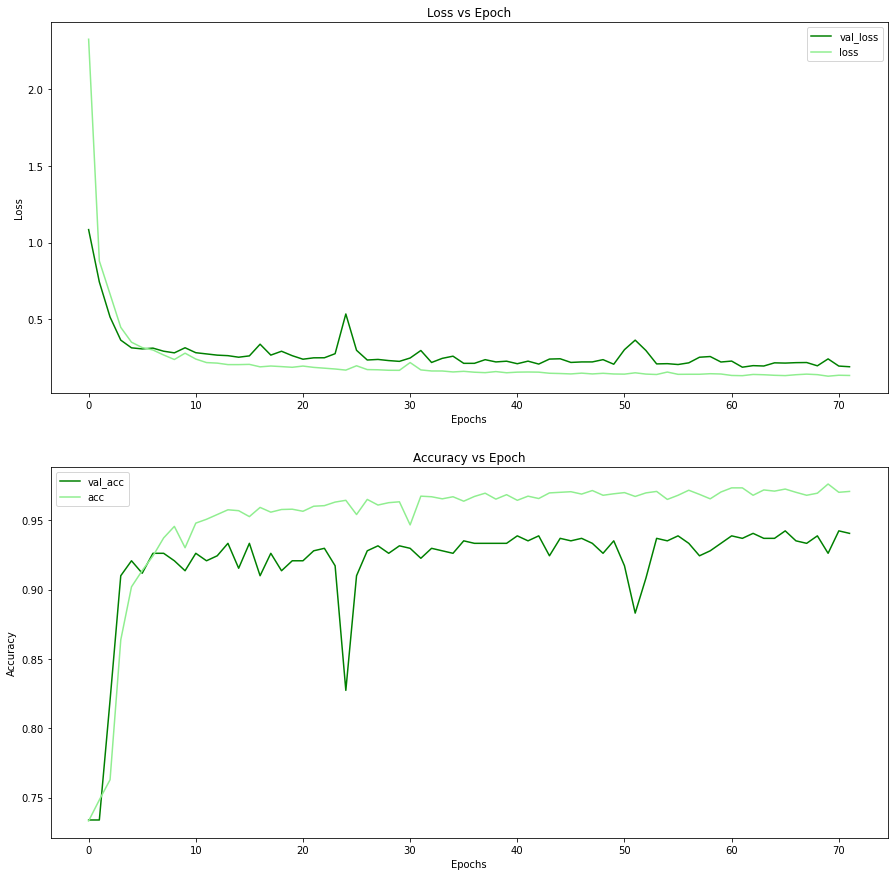

In [185]:
get_plots(cnn_deep_l2_history, title='deep_cnn_l2_plots.png')

# Data augmentation Model

I will now attempt to improve the model by performing data augmentation. Data augmentation alters the existing images on the fly to provide the model with variations that are in a sense a completely new image to train on. For projects where the training data is quite small (as is the case here) this can be an extremely valuable tool.

In [26]:
training_generator_aug=ImageDataGenerator(rescale=1/255,featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)
train_generator_aug=training_generator_aug.flow_from_directory(train_data,target_size=(100,100),batch_size=4,class_mode='binary')

Found 4676 images belonging to 2 classes.


In [27]:
validation_generator=ImageDataGenerator(rescale=1/255)
val_generator=validation_generator.flow_from_directory(val_data,target_size=(100,100),batch_size=4,class_mode='binary')

Found 556 images belonging to 2 classes.


In [28]:

test_generator=ImageDataGenerator(rescale=1/255)
test_generator=test_generator.flow_from_directory(test_data,target_size=(100,100),batch_size=4,class_mode='binary')

Found 624 images belonging to 2 classes.


In [38]:
aug_model=models.Sequential([
    layers.Conv2D(32,(3,3),input_shape=(100,100,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    
    layers.Conv2D(256,(3,3),activation='relu'), 
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(256,activation='relu'),
    layers.Dense(1,activation='sigmoid')
    
])

In [39]:
aug_model.compile(loss = 'binary_crossentropy',
              optimizer = 'Nadam',
              metrics = ['accuracy'])

In [40]:
aug_model_history = aug_model.fit_generator(train_generator_aug,
            validation_data = val_generator,
            
            epochs = 30,
            
            verbose = 1)

Epoch 1/30
1169/1169 [==============================] - 228s 195ms/step - loss: 0.4589 - accuracy: 0.7896 - val_loss: 0.6234 - val_accuracy: 0.7140
Epoch 2/30
1169/1169 [==============================] - 229s 196ms/step - loss: 0.2995 - accuracy: 0.8670 - val_loss: 0.2305 - val_accuracy: 0.9191
Epoch 3/30
1169/1169 [==============================] - 227s 195ms/step - loss: 0.2658 - accuracy: 0.8762 - val_loss: 0.2420 - val_accuracy: 0.8849
Epoch 4/30
1169/1169 [==============================] - 225s 192ms/step - loss: 0.2276 - accuracy: 0.8991 - val_loss: 0.2466 - val_accuracy: 0.9173
Epoch 5/30
1169/1169 [==============================] - 230s 197ms/step - loss: 0.2150 - accuracy: 0.9095 - val_loss: 0.2199 - val_accuracy: 0.9101
Epoch 6/30
1169/1169 [==============================] - 231s 197ms/step - loss: 0.1978 - accuracy: 0.9213 - val_loss: 0.2250 - val_accuracy: 0.9029
Epoch 7/30
1169/1169 [==============================] - 227s 194ms/step - loss: 0.1918 - accuracy: 0.9224 - val_

In [41]:
print("Loss of the model is - " , aug_model.evaluate(test_generator)[0]*100 , "%")
print("Accuracy of the model is - " , aug_model.evaluate(test_generator)[1]*100 , "%")

156/156 [==============================] - 16s 99ms/step - loss: 0.2490 - accuracy: 0.9295
Loss of the model is -  24.897007644176483 %
156/156 [==============================] - 15s 96ms/step - loss: 0.2490 - accuracy: 0.9295
Accuracy of the model is -  92.94871687889099 %


In [78]:
test_generator_aug=ImageDataGenerator(rescale=1/255)
test_generator_aug=test_generator_aug.flow_from_directory(test_data,target_size=(100,100),batch_size=624)
test_images_aug, test_labels_aug = next(test_generator_aug)
test_img_aug = test_images_aug.reshape(624,-1)
test_lab_aug = np.reshape(test_labels_aug[:,1],(624,1))

Found 624 images belonging to 2 classes.


In [79]:
y_pred_aug = aug_model.predict(test_images_aug)
y_pred_aug = np.rint(y_pred_aug)
print(classification_report(test_lab_aug, y_pred_aug, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       234
           1       0.91      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



In [94]:
cm_aug=confusion_matrix(test_lab_aug, y_pred_aug)

Confusion matrix, without normalization


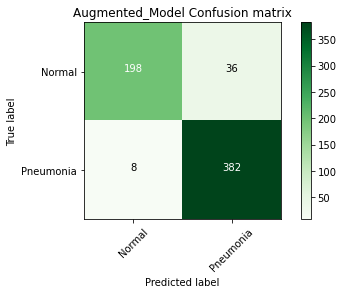

In [240]:
plot_confusion_matrix(cm=cm_aug,classes=['Normal', 'Pneumonia'], filename='Augmented_Model')

In [120]:
def get_plots(history, title='default.png'):
    fig, axs = plt.subplots(2,figsize=(15,15))
    axs[0].plot(history.history['val_loss'], color='green')
    axs[0].plot(history.history['loss'], color='lightgreen')
    axs[0].legend(['val_loss', 'loss'])
    axs[0].set_title('Loss vs Epoch')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    
    axs[1].plot(history.history['val_accuracy'], color='green')
    axs[1].plot(history.history['accuracy'], color='lightgreen')
    axs[1].legend(['val_acc', 'acc'])
    axs[1].set_title('Accuracy vs Epoch')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    plt.show()
    fig.savefig('figures/'+title, bbox_inches='tight')

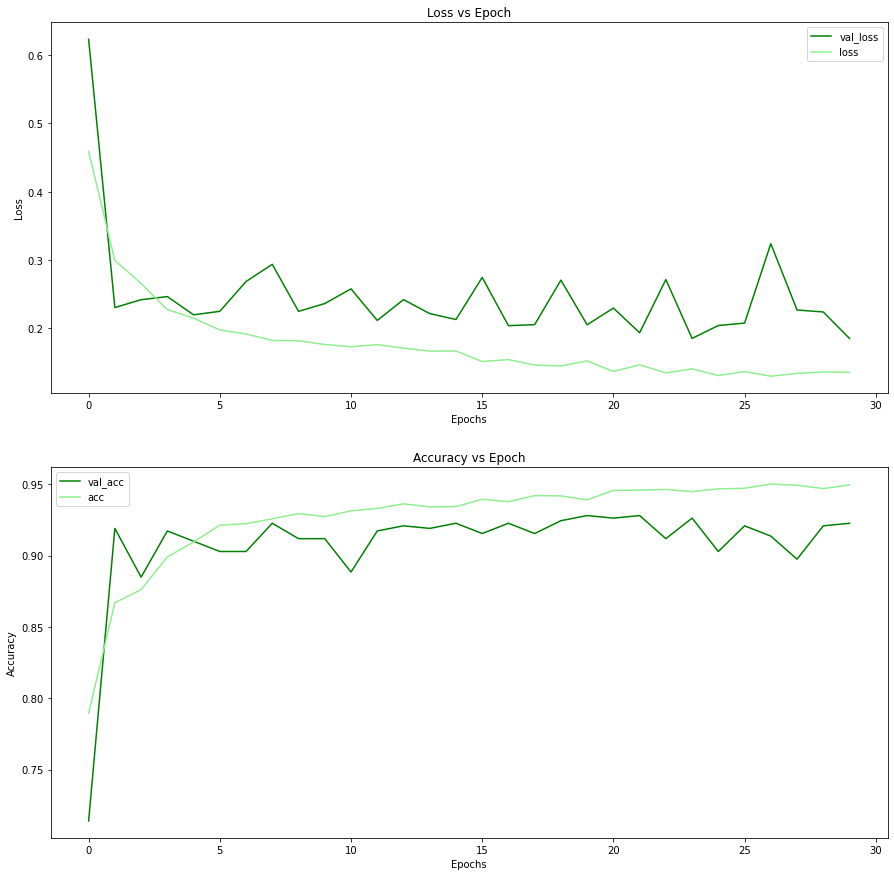

In [121]:
get_plots(aug_model_history, title='data_aug_plots.png')

In [127]:
# save the model
aug_model.save("models/aug_model.h5")

Still some indication of overfitting to the training data present, but it is clear that adding dropout layers has improved the model. 
The accuracy of the model has increased, as well as the recall of the "normal class". Although it is more important that recall is high on the pneumonia class, (and it is at 0.99), meaning very few false negatives,

### Visualize the Augmented Data

An example of the type of augmentation that is done on one image provides an example of how one image can become three totally different images in the eyes of a computer. This is a really valuable tool for small datasets.

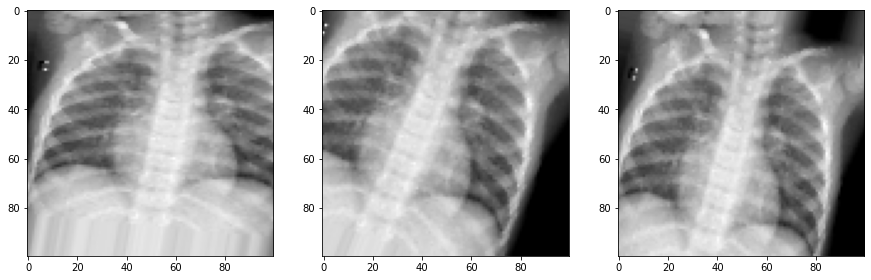

In [197]:
names = [os.path.join(train_normal, name) for name in os.listdir(train_normal)]
img_path = names[91]
img = load_img(img_path, target_size=(100, 100))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for batch in training_generator_aug.flow(reshape_img, batch_size=1):
    ax[i].imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()
fig.savefig('figures/augmented_images.png', bbox_inches='tight')


In [100]:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Greens, filename='Default'):
 
    #Add Normalization Option
   #‘’’prints pretty confusion metric with normalization option ‘’’
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(filename+ ' ' +title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('figures/'+filename, bbox_inches = "tight")

# Transfer Learning

In [261]:
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(100, 100, 3))

80142336/80134624 [==============================] - 15s 0us/step


In [262]:
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [267]:
transfer_learning = models.Sequential()
transfer_learning.add(cnn_base)
transfer_learning.add(layers.Dropout(0.3))
transfer_learning.add(Flatten())
transfer_learning.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
transfer_learning.add(layers.Dropout(0.3))
transfer_learning.add(Dense(1, activation='sigmoid'))

In [268]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in transfer_learning.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(transfer_learning.trainable_weights))

vgg19 False
dropout_8 True
flatten_13 True
dense_66 True
dropout_9 True
dense_67 True
4


In [265]:
cnn_base.trainable = False

In [266]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in transfer_learning.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(transfer_learning.trainable_weights))

vgg19 False
flatten_12 True
dense_64 True
dense_65 True
4


In [269]:
transfer_learning.compile(loss='binary_crossentropy',
                optimizer='Nadam',
                metrics=['accuracy'])

callbacks_4 = [EarlyStopping(monitor='val_loss', patience=10, verbose=0), 
                  ModelCheckpoint(filepath='models/best_vgg19.h5', monitor='val_loss', save_best_only=True)]

In [270]:
vgg_19 = transfer_learning.fit(train_images1,
                       train_lab1,
                       epochs=100,
                       batch_size=100,
                       validation_data=(val_images1, val_lab1), callbacks=callbacks_4)

Epoch 1/100
47/47 [==============================] - 408s 9s/step - loss: 0.6089 - accuracy: 0.8692 - val_loss: 0.4995 - val_accuracy: 0.8503
Epoch 2/100
47/47 [==============================] - 423s 9s/step - loss: 0.3065 - accuracy: 0.9282 - val_loss: 0.2798 - val_accuracy: 0.9386
Epoch 3/100
47/47 [==============================] - 447s 10s/step - loss: 0.2513 - accuracy: 0.9391 - val_loss: 0.2848 - val_accuracy: 0.9213
Epoch 4/100
47/47 [==============================] - 438s 9s/step - loss: 0.2342 - accuracy: 0.9425 - val_loss: 0.4345 - val_accuracy: 0.8330
Epoch 5/100
47/47 [==============================] - 415s 9s/step - loss: 0.2104 - accuracy: 0.9521 - val_loss: 0.2117 - val_accuracy: 0.9443
Epoch 6/100
47/47 [==============================] - 409s 9s/step - loss: 0.2004 - accuracy: 0.9514 - val_loss: 0.1677 - val_accuracy: 0.9616
Epoch 7/100
47/47 [==============================] - 401s 9s/step - loss: 0.1999 - accuracy: 0.9512 - val_loss: 0.2517 - val_accuracy: 0.9136
Epoch

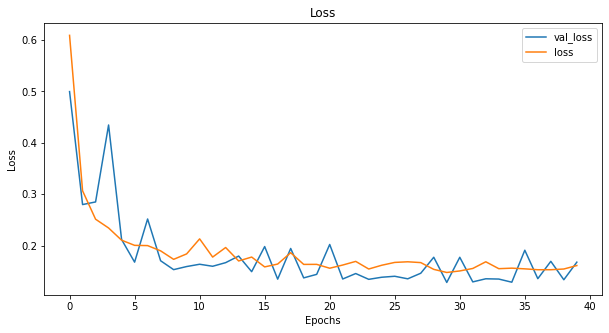

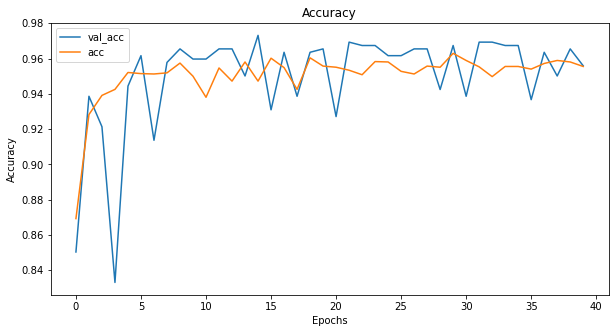

In [271]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(x, y)
axs[1].plot(x, -y)
fig.figure(figsize=(10,5))
    plt.plot(vgg_19.history['val_loss'])
    plt.plot(vgg_19.history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(vgg_19.history['val_accuracy'])
    plt.plot(vgg_19.history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [272]:
saved_model4 = load_model('models/best_vgg19.h5')

In [273]:
y_pred5 = saved_model4.predict(test_images1)
y_pred5 = np.rint(y_pred5)
print(classification_report(test_lab1, y_pred5, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.98      0.40      0.57       234
           1       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.86      0.70      0.70       624
weighted avg       0.83      0.77      0.74       624



In [274]:
cm_vgg19 = confusion_matrix(test_lab1, y_pred5)

Confusion matrix, without normalization


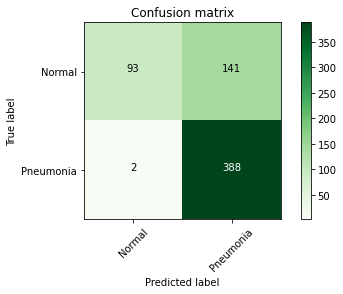

In [275]:
plot_confusion_matrix(cm_vgg19, ['Normal', 'Pneumonia'])

# Conclusions

The best model was the model that utilised augmentation to complement the existing training data set. 

On the hold out data the model achieved a high accuracy of 0.93

In [198]:
print(classification_report(test_lab_aug, y_pred_aug, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       234
           1       0.91      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



The recall and precision in the minority class (Normal) was also the highest achieved in any of the models. The recall of the PNEUMONIA class was not the best recorded at 0.98 vs 0.99 achieved in the other models. However these models had an unnacceptable recall in the Normal class, meaning many patients would go onto to be misdiagnosed with pneumonia.

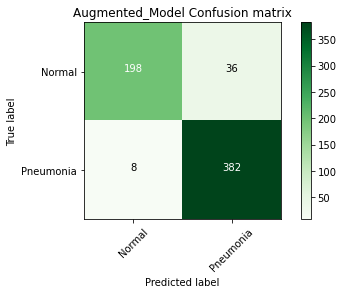

As can be seen, still a very small number (8) was seen to be 'NORMAL' whilst actually suffering from pneumonia. For comparison the lowest this number got to in other models was 2, meaning the model of choice misses 6 people with pneumonia that other models didn't miss. 

This is an interesting choice therefore, why would I pick a model that misses more pneumonia?

The recall of the NORMAL class is vitally important too, and the difference between the best model in this metric (0.85) was so much higher than the next best (0.56). I see this as an unnacceptable number of people being diagnosed with Pneumonia that don't have it. This could potentially stop a patient being treated for the real underlying cause of their ailment and missing something more serious and or lead to perfectly healthy patients being treated for pneumonia that don't have it. This can waste valuable resources not only in terms of money on drugs, but also time of consultants etc.

## Further Work

- As with any project, more data the better. This dataset was relatively small at just 1000s of images. Ideally this would be in 10,000s or even 100,000s or into the millions. Of course this would then be beyond the limitations of my personal computer and would need to be cloud based

- Address the class imbalance to see if this has any impact on performance.

- Further tuning of the final model could be carried out in an attempt to increase performance.

- Due to time constraints, I only experimented with one pre-trained model, ideally I would expand this to the list below:
    - DenseNet
    - InceptionResNetV2
    - InceptionV3
    - MobileNet
    - NASNet
    - ResNet50
    - VGG16
    - Xception